In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_dir = os.path.join('/nas/ucb/rmovva/data/hypothesaes')

model_name_map = {
    "HuggingFaceTB/SmolLM3-3B": "SmolLM3-3B",
    "meta-llama/Llama-3.2-3B-Instruct": "Llama-3.2-3B",
    "mistralai/Mistral-7B-Instruct-v0.3": "Mistral-7B-v0.3",
    "meta-llama/Llama-3.1-8B-Instruct": "Llama-3.1-8B",
}

def abbrev_model_name(full_model):
    if '_think=True' in full_model:
        model_name = full_model.replace('_think=True', '')
        suffix = '-think'
    elif '_think=False' in full_model:
        model_name = full_model.replace('_think=False', '')
        suffix = ''
    else:
        model_name = full_model
        suffix = ''
    if model_name in model_name_map:
        model_name = model_name_map[model_name]
    if '/' in model_name:
        model_name = model_name.split('/')[-1]
    return model_name + suffix

## Evaluating autointerp: compute interpretation fidelities

In [ ]:
import os
import pickle

fidelities = pickle.load(open(os.path.join(base_dir, 'local_llm_experiments', 'results', 'fidelities_1024_32.pkl'), "rb"))

metric = 'correlation'

# Remap fidelities keys to their abbreviations
fidelities_abbrev = {}
for model, model_fidelities in fidelities.items():
    abbrev = abbrev_model_name(model)
    fidelities_abbrev[abbrev] = model_fidelities
fidelities = fidelities_abbrev

# Get metric values for each model, using abbreviated model names as keys
model_metrics = {}
for abbrev, model_fidelities in fidelities.items():
    metrics = []
    for neuron_idx, neuron_data in model_fidelities.items():
        if neuron_data:  # Skip empty neurons
            neuron_metrics = [interp_data[metric] for interp_data in neuron_data.values()]
            if neuron_metrics:
                metrics.append(max(neuron_metrics))
    model_metrics[abbrev] = metrics

sorted_models = sorted(model_metrics.keys(), key=lambda m: np.median(model_metrics[m]) if model_metrics[m] else 0, reverse=True)

In [121]:
# Get all models including the missing one
all_models = ["gpt-4.1", "Qwen3-32B-AWQ-think", "Qwen3-14B-think", "Qwen3-8B-think", "Qwen3-32B-AWQ"]

# Get all neurons that have data across models
neurons_with_data = fidelities['gpt-4.1'].keys()

# Sample 5 random neurons
sample_neurons = np.random.choice(list(neurons_with_data), size=min(5, len(neurons_with_data)), replace=False)

for neuron_idx in sample_neurons:
    print(f"Neuron {neuron_idx}:")
    for model in all_models:
        if model in fidelities and neuron_idx in fidelities[model] and fidelities[model][neuron_idx]:
            # Find best interpretation for this neuron and model
            best_interp = max(fidelities[model][neuron_idx].items(), key=lambda x: x[1][metric])
            model_name = abbrev_model_name(model)
            print(f"- {model_name}: {best_interp[0]} (corr={best_interp[1][metric]:.3f})")
    print()


Neuron 687:
- gpt-4.1: mentions the Seminole Heights neighborhood or Seminole area (corr=0.851)
- Qwen3-32B-AWQ-think: mentions Seminole Heights or Seminole mall area (corr=0.766)
- Qwen3-14B-think: mentions Seminole Heights (corr=0.715)
- Qwen3-8B-think: mentions the restaurant's location in Seminole Heights or Seminole mall area (corr=0.766)
- Qwen3-32B-AWQ: mentions the Seminole Heights neighborhood specifically (corr=0.653)

Neuron 444:
- gpt-4.1: mentions dishes or restaurants with names or descriptions containing 'mac', such as macadamia, macaroni, macaroons, or establishments with 'Mac' in their name (corr=0.818)
- Qwen3-32B-AWQ-think: mentions macaroni, macaroons, or macarons (corr=0.851)
- Qwen3-14B-think: mentions dishes or ingredients containing 'mac' (e.g., macadamia, macaroni, macaroons, Macaroni Grill, Macnivens) (corr=0.814)
- Qwen3-8B-think: mentions macadamia nuts or macaroons (corr=0.512)
- Qwen3-32B-AWQ: mentions macarons or macaroons and describes their taste, quali

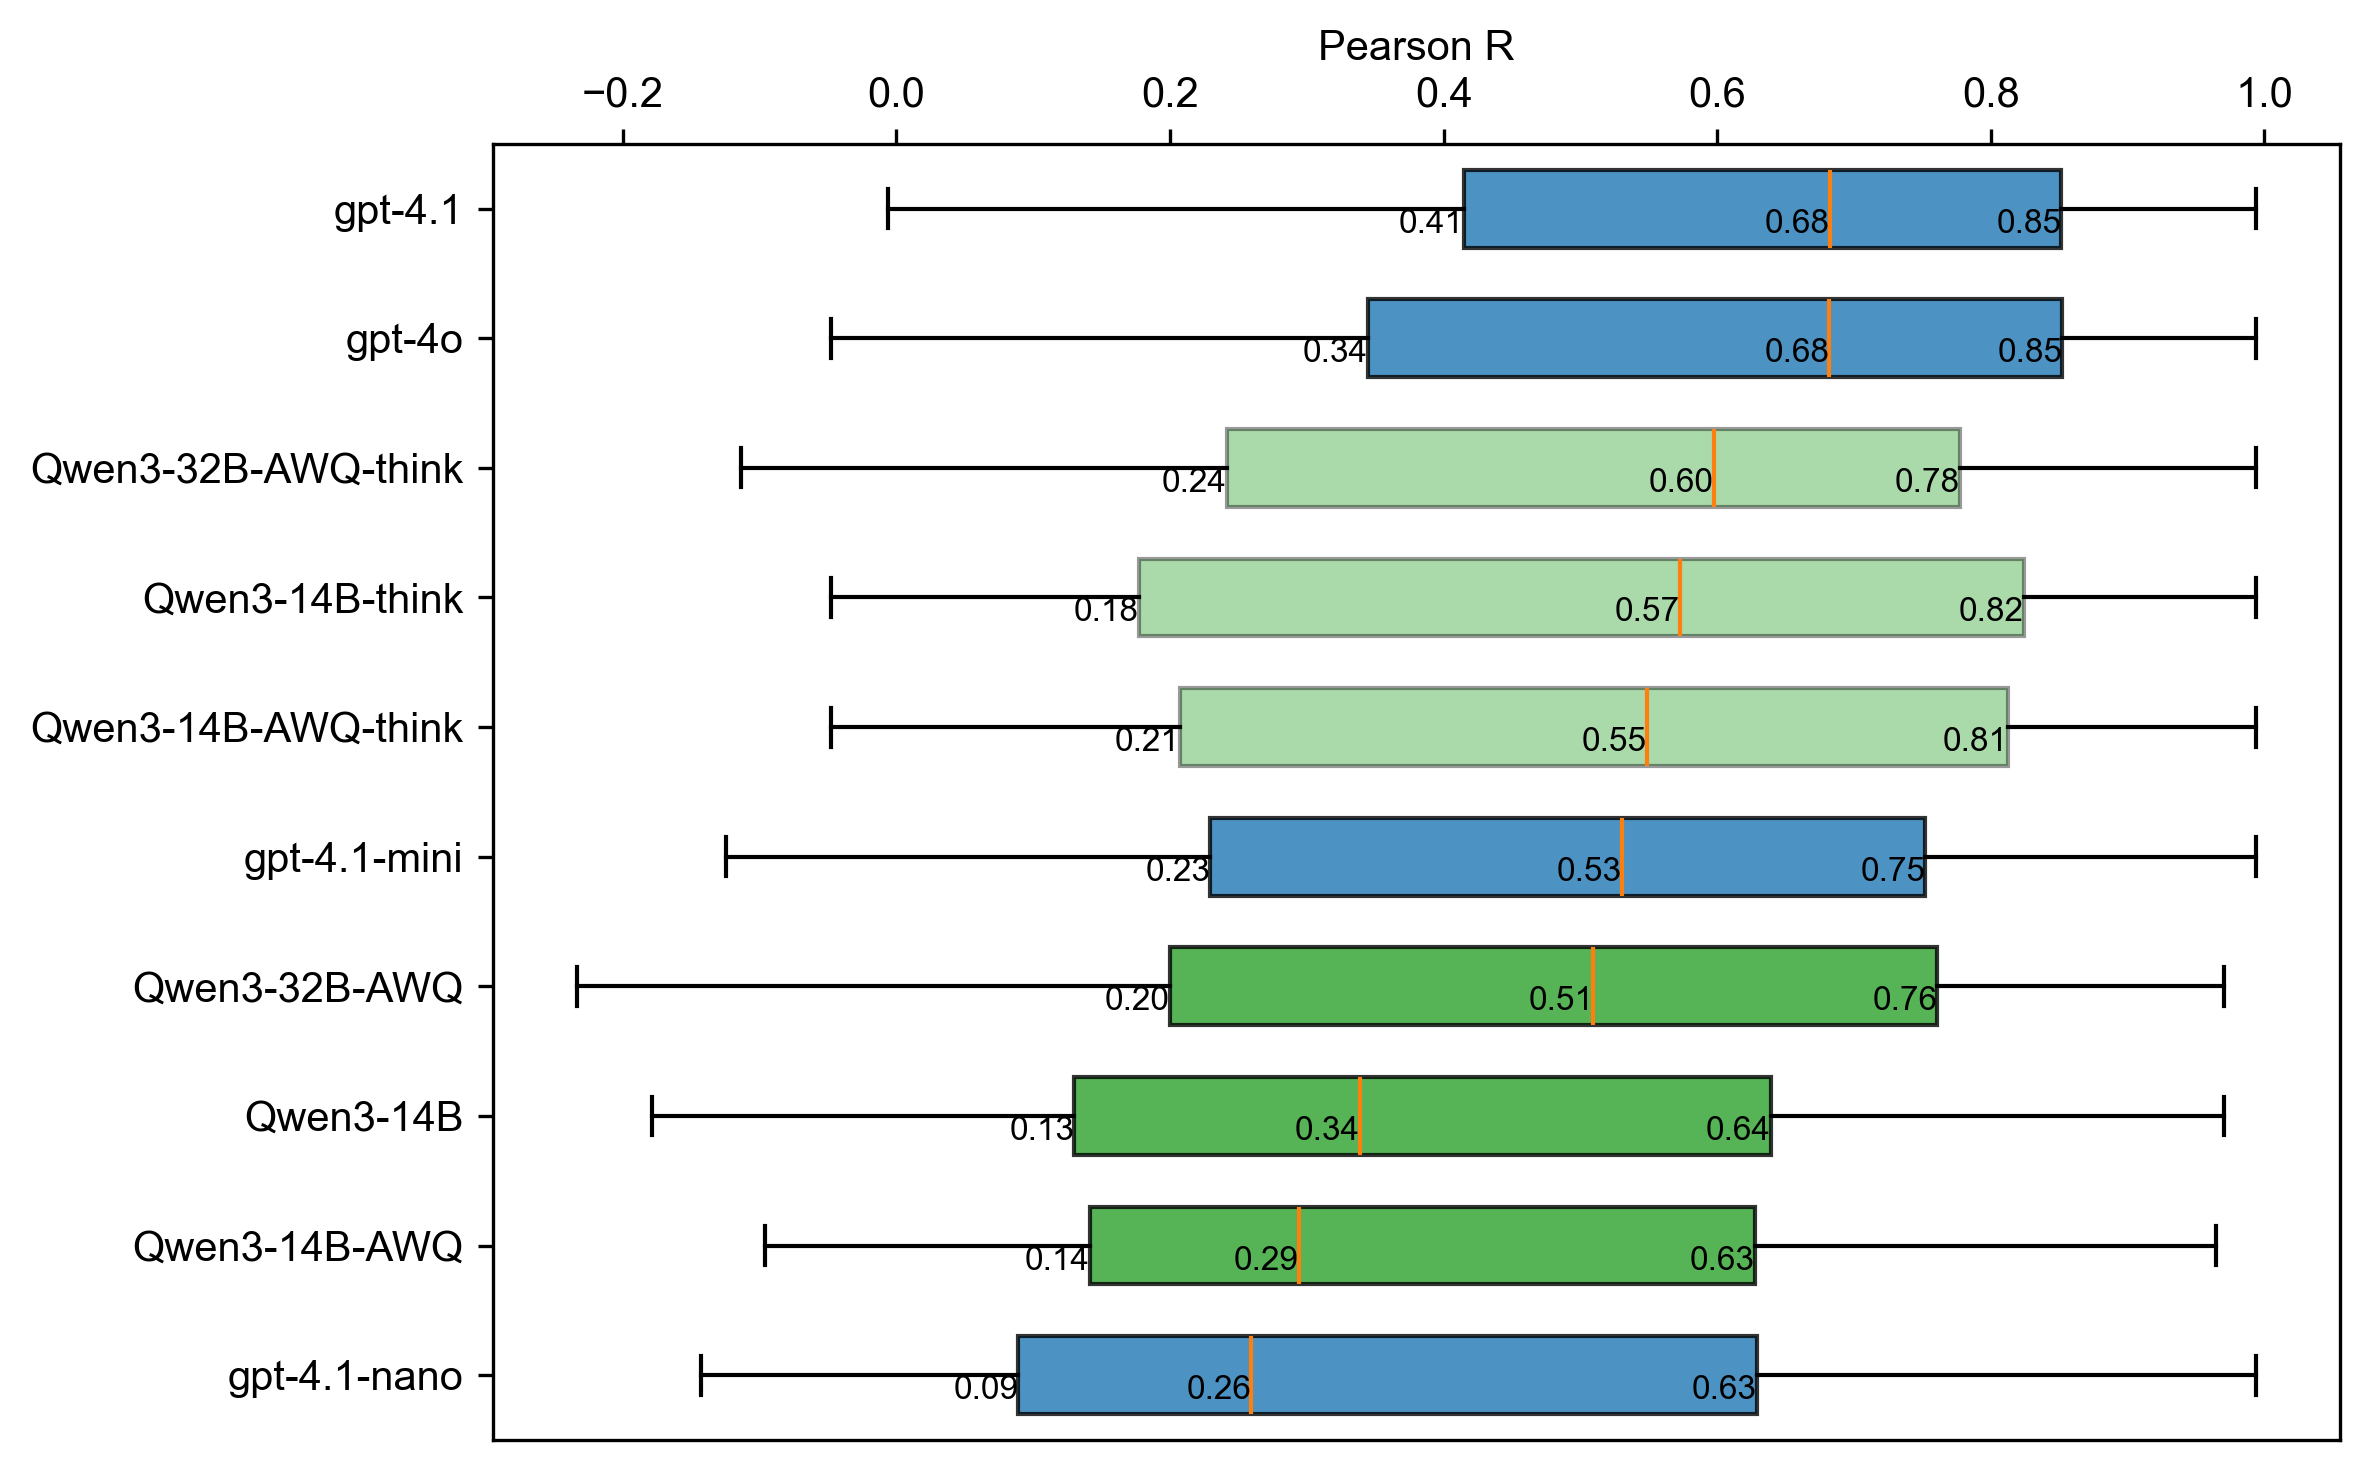

In [ ]:
data_for_plot = []
model_labels = []
alphas = []
colors = []
for model in sorted_models:
    if '8B' in model:
        continue
    model_name = model  # Use the key directly, no abbreviation
    thinking = '-think' in model_name
    alpha = 0.4 if thinking else 0.8
    color = 'C0' if 'gpt' in model_name.lower() else 'C2'
    data_for_plot.extend(model_metrics[model])
    model_labels.extend([model_name] * len(model_metrics[model]))
    alphas.extend([alpha] * len(model_metrics[model]))
    colors.extend([color] * len(model_metrics[model]))

plot_df = pd.DataFrame({'Model': model_labels, metric.upper(): data_for_plot, 'Alpha': alphas, 'Color': colors})

plt.figure(figsize=(8, len(plot_df['Model'].unique()) // 2), dpi=300)
ax = plt.gca()
for i, model_name in enumerate(plot_df['Model'].unique()):
    model_data = plot_df[plot_df['Model'] == model_name]
    alpha = model_data['Alpha'].iloc[0]
    color = model_data['Color'].iloc[0]
    box_data = model_data[metric.upper()]
    bp = ax.boxplot(box_data, positions=[i], widths=0.6, patch_artist=True, vert=False)
    bp['boxes'][0].set_alpha(alpha)
    if color:
        bp['boxes'][0].set_facecolor(color)
    median = np.median(box_data)
    q25 = np.percentile(box_data, 25)
    q75 = np.percentile(box_data, 75)
    ax.text(median, i, f'{median:.2f}', ha='right', va='top', fontsize=8)
    ax.text(q25, i, f'{q25:.2f}', ha='right', va='top', fontsize=8)
    ax.text(q75, i, f'{q75:.2f}', ha='right', va='top', fontsize=8)

ax.set_yticklabels(plot_df['Model'].unique(), rotation=0, ha='right')
ax.set_xlabel("Pearson R")

# Labels on the top of the plot
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.show()


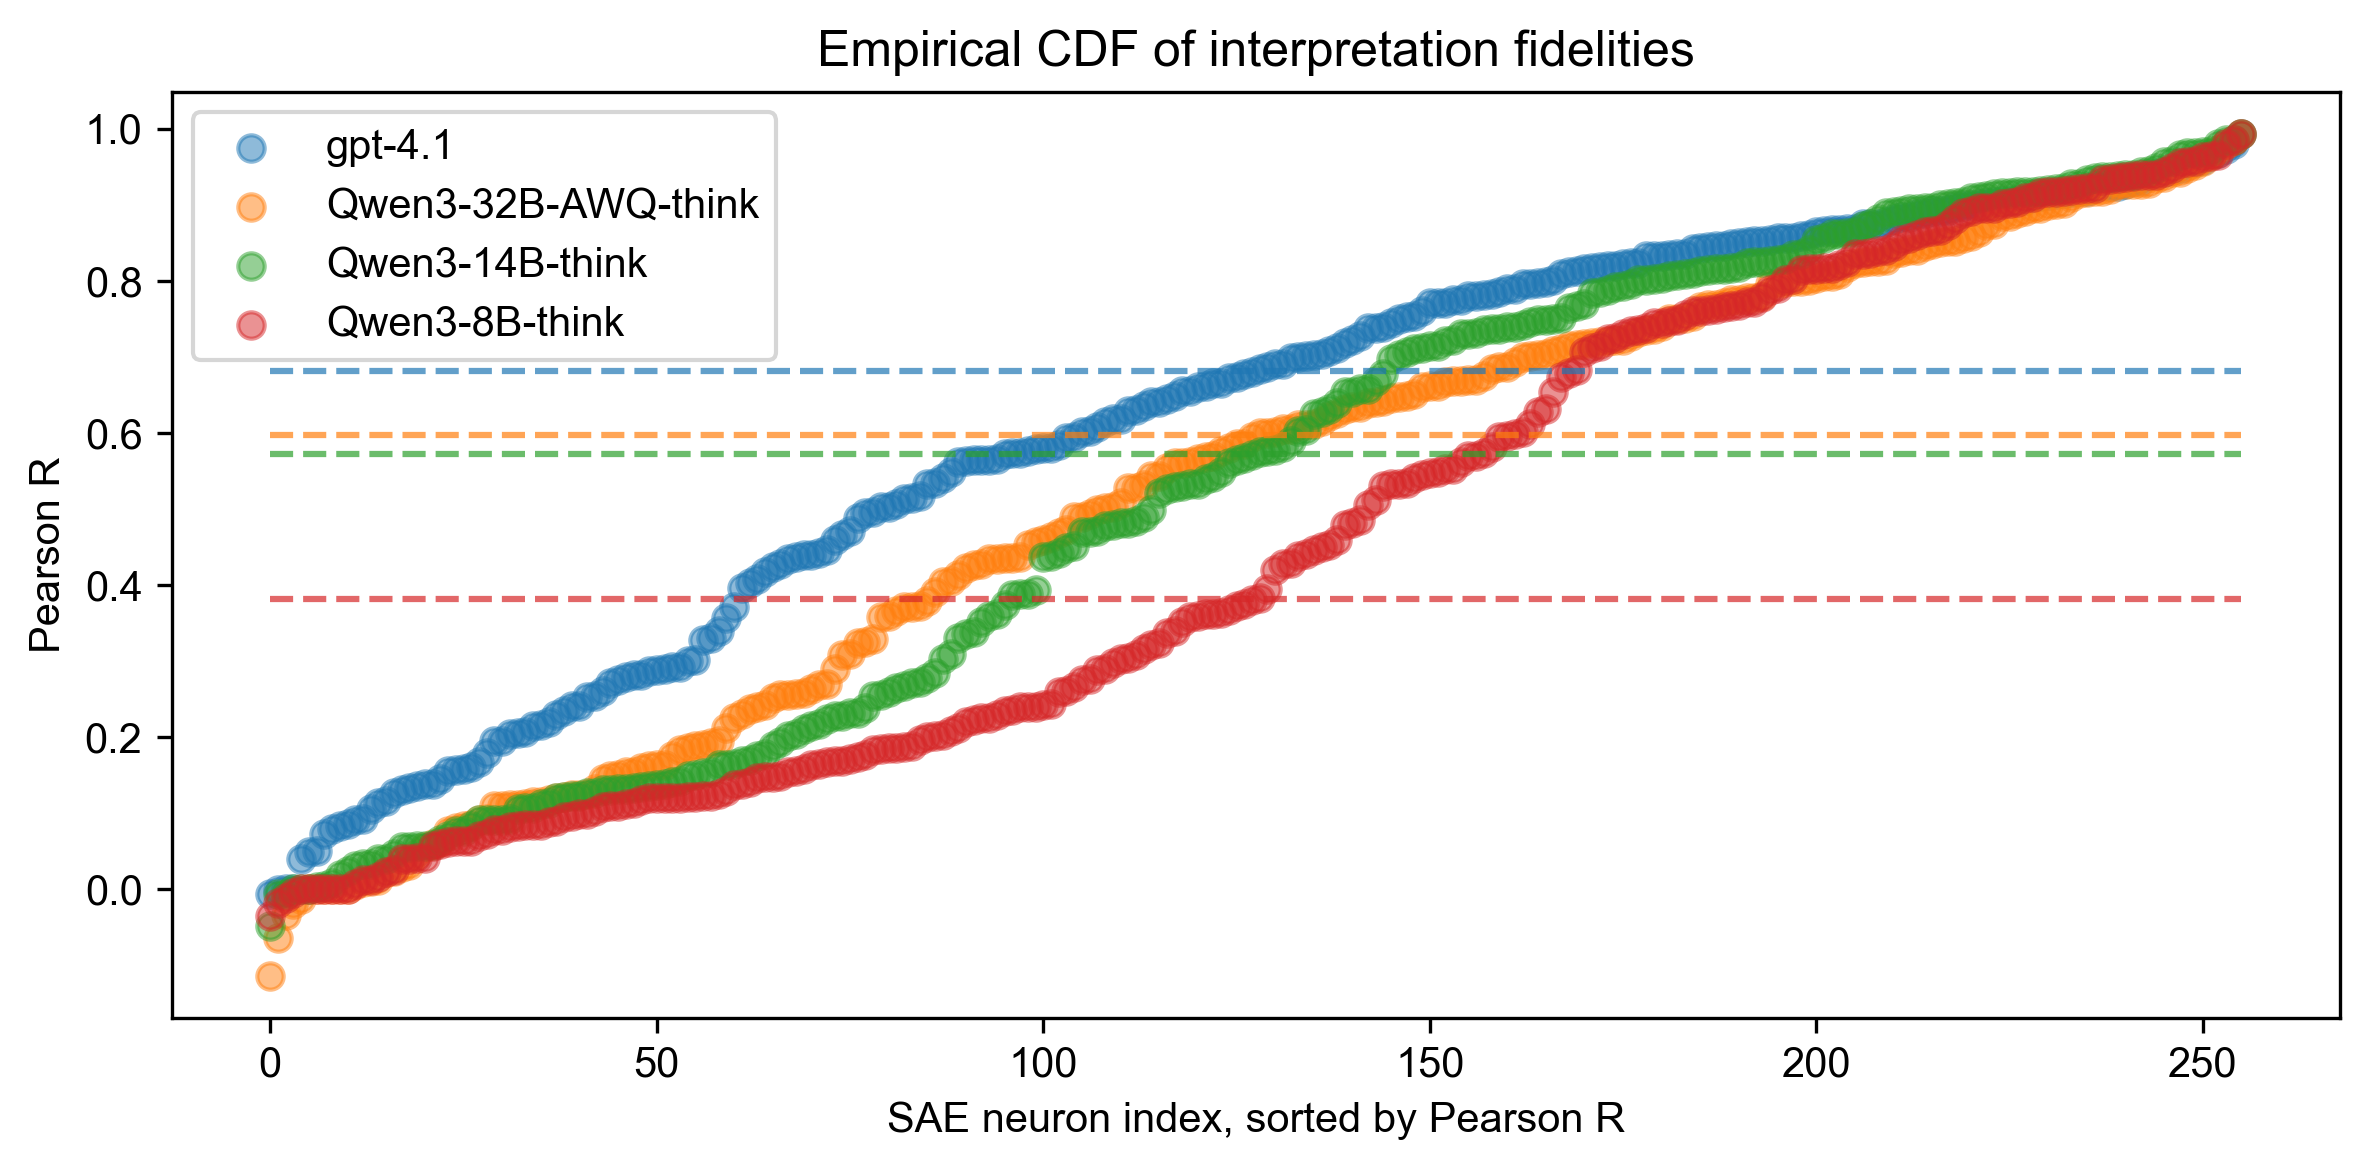

In [119]:
# 1) choose models -----------------------------------------------------------
reference = "gpt-4.1"            # sorting model
# reference = "Qwen/Qwen3-32B-AWQ_think=True"
others    = ["Qwen3-32B-AWQ-think", "Qwen3-14B-think", "Qwen3-8B-think"]     # models to compare
models    = [reference] + others

# Sort by reference model or individually
sort_by_reference = False  # Set to False to sort each model individually

# 2) load data ---------------------------------------------------------------
data = model_metrics

missing = [m for m in models if m not in data]
if missing:
    raise KeyError(f"Models not in model_metrics: {missing}")

# 3) gather F1 vectors -------------------------------------------------------
f1_by_model = {m: data[m] for m in models}

# Sort indices based on flag
if sort_by_reference:
    # Sort all models by reference model performance
    reference_scores = f1_by_model[reference]
    sorted_indices = sorted(range(len(reference_scores)), key=lambda i: reference_scores[i])

# 4) plot --------------------------------------------------------------------
plt.figure(figsize=(8, 4), dpi=300)
colors = plt.cm.tab10.colors

for i, (m, scores) in enumerate(f1_by_model.items()):
    if sort_by_reference:
        # Sort scores according to reference model ordering
        sorted_scores = np.array([scores[idx] for idx in sorted_indices])
    else:
        # Sort each model individually
        sorted_scores = np.array(sorted(scores))
    
    plt.scatter(
        range(len(sorted_scores)),
        sorted_scores,
        s=40,
        alpha=0.5,
        label=m,
        color=colors[i % len(colors)],
    )
    plt.hlines(
        np.median(sorted_scores),
        0,
        len(sorted_scores) - 1,
        ls="--",
        color=colors[i % len(colors)],
        alpha=0.7,
    )

plt.xlabel(f"SAE neuron index, sorted by Pearson R")
plt.ylabel("Pearson R")
plt.title("Empirical CDF of interpretation fidelities")
plt.legend()
plt.tight_layout()
plt.show()

In [113]:
from scipy.stats import ttest_rel

def compare_models(model1_key, model2_key, label1, label2):
    scores1 = data[model1_key]
    scores2 = data[model2_key]
    t_stat, p_value = ttest_rel(scores1, scores2)
    mean_diff = np.mean(scores1) - np.mean(scores2)
    print(f"{label1} vs {label2}: p={p_value:.3f}, sig={p_value < 0.05}, mean_diff={mean_diff:.3f}")

compare_models('gpt-4.1', 'Qwen3-14B-think', 'GPT-4.1', 'Qwen14B-think')
compare_models('Qwen3-14B-think', 'Qwen3-8B-think', 'Qwen14B-think', 'Qwen8B-think')
compare_models('Qwen3-32B-AWQ-think', 'Qwen3-32B-AWQ', 'Qwen32B-AWQ-think', 'Qwen32B-AWQ-no-think')
compare_models('Qwen3-14B-think', 'Qwen3-32B-AWQ-think', 'Qwen14B-think', 'Qwen32B-AWQ-think')


GPT-4.1 vs Qwen14B-think: p=0.000, sig=True, mean_diff=0.086
Qwen14B-think vs Qwen8B-think: p=0.000, sig=True, mean_diff=0.072
Qwen32B-AWQ-think vs Qwen32B-AWQ-no-think: p=0.006, sig=True, mean_diff=0.036
Qwen14B-think vs Qwen32B-AWQ-think: p=0.848, sig=False, mean_diff=0.003


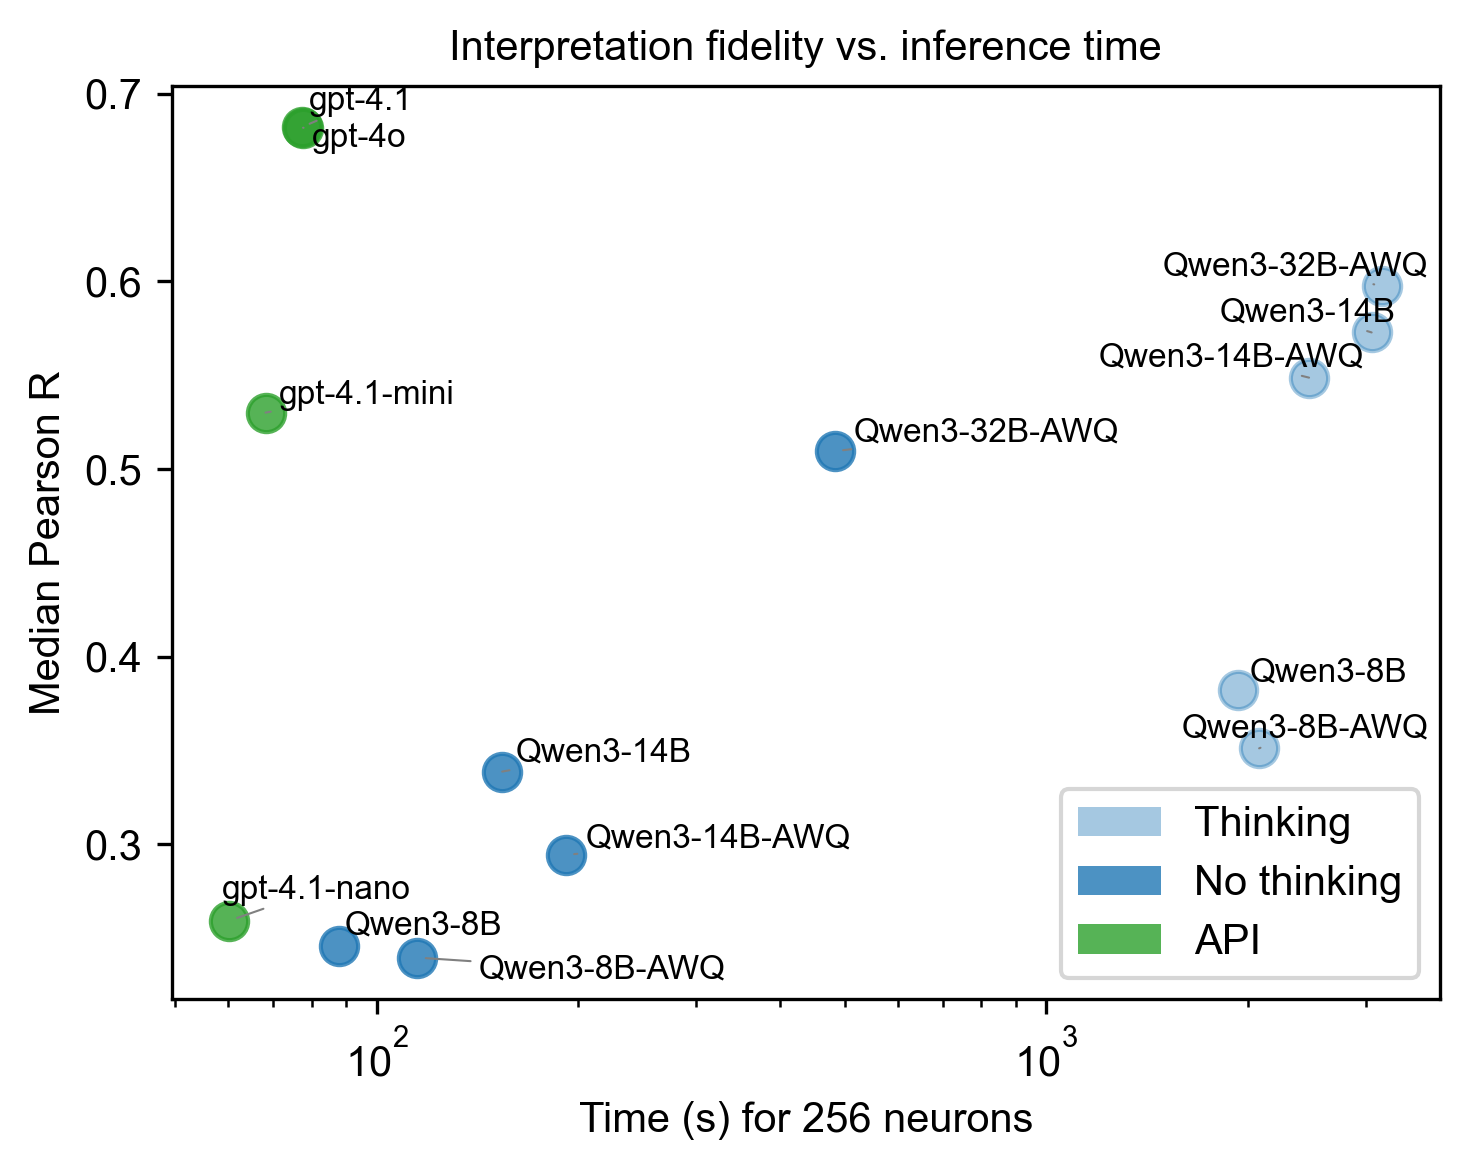

In [118]:
import json
from adjustText import adjust_text

# Load timing data
timing_file = "/nas/ucb/rmovva/data/hypothesaes/local_llm_experiments/results/interpretation_timing_results_1024_32.jsonl"
timing_data = []
with open(timing_file, 'r') as f:
    for line in f:
        timing_data.append(json.loads(line.strip()))

plt.figure(figsize=(5, 4), dpi=300)
texts = []

for timing_entry in timing_data:
    model_name = abbrev_model_name(timing_entry["model_name"])
    time_taken = timing_entry["time (s)"]
    thinking = timing_entry.get("thinking", False)
    
    model_key = f"{model_name}-think" if thinking else f"{model_name}"
    if model_key in data:
        median_f1 = np.median(data[model_key])
        
        if "gpt" in model_name.lower():
            color = "C2"
            display_name = model_name
        else:
            color = "C0"
            display_name = model_name.split('/')[-1]
        
        alpha = 0.4 if thinking else 0.8
        legend_label = f"{display_name} ({'thinking' if thinking else 'no thinking'})"
        
        plt.scatter(time_taken, median_f1, color=color, alpha=alpha, 
                   s=80, marker='o', label=legend_label)
        
        # Collect text objects for adjusttext
        txt = plt.text(time_taken, median_f1, display_name, fontsize=8, ha='left')
        texts.append(txt)

plt.xscale('log')
plt.xlabel("Time (s) for 256 neurons")
plt.ylabel("Median Pearson R")
plt.title("Interpretation fidelity vs. inference time", fontsize=10)
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='C0', alpha=0.4, label='Thinking'),
    Patch(facecolor='C0', alpha=0.8, label='No thinking'),
    Patch(facecolor='C2', alpha=0.8, label='API'),
]
plt.legend(handles=legend_elements)
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
plt.tight_layout()
plt.show()


## Evaluating annotation: compare to GPT-4.1

1. Take 5 concepts from Yelp reported in the paper, and 2000 sample texts from the validation set
2. Annotate all texts for all concepts (total: 10000 binary annotation tasks) with GPT-4.1 as "ground truth"
3. Generate annotations using our local LLM code, and compute F1 scores with GPT-4.1
4. Also report time taken with one A6000  

Notes:
- We use a separate script `generate_local_annotations.py` to compute annotations for local LLMs.  
This is because we can't store many LLMs in GPU memory at once, so we run each model sequentially and store their annotations in a separate file

- We compute annotations for a few other closed OpenAI models in this notebook.

### Load data

In [2]:
import pickle

from generate_local_annotations import (
    ANNOTATIONS_PATH,
    CONCEPTS,
    DATA_PATH
)

reviews = pd.read_json(DATA_PATH, lines=True)["text"].tolist()

with open(ANNOTATIONS_PATH, "rb") as fh:
    model_outputs: dict = pickle.load(fh)

rows = [(concept, txt) for concept in CONCEPTS for txt in reviews]
df_annotations = pd.DataFrame(rows, columns=["concept", "text"])

for model_name, annotations in model_outputs.items():
    # annotations format: {concept: {text: label}}
    flat = []
    for concept in CONCEPTS:
        concept_dict = annotations.get(concept, {})
        flat.extend(concept_dict.get(txt) for txt in reviews)
    df_annotations[abbrev_model_name(model_name)] = flat

print(df_annotations.shape)
print(df_annotations.columns)

(10000, 20)
Index(['concept', 'text', 'SmolLM3-3B-think', 'SmolLM3-3B', 'Llama-3.2-3B',
       'Qwen3-0.6B-think', 'Qwen3-0.6B', 'Qwen3-4B-think', 'Qwen3-4B',
       'Qwen3-8B-think', 'Qwen3-8B', 'Qwen3-14B-think', 'Qwen3-14B',
       'Qwen3-32B-AWQ-think', 'Qwen3-32B-AWQ', 'gpt-4.1', 'gpt-4.1-mini',
       'gpt-4.1-nano', 'gpt-4o', 'Llama-3.1-8B'],
      dtype='object')


In [ ]:
from hypothesaes.annotate import annotate
from hypothesaes.annotate import CACHE_DIR

start = time()
# Use o3 to compute "ground truth" annotations
gt_model = 'o4-mini'
tasks = list(zip(df_annotations['text'], df_annotations['concept']))
ground_truth = annotate(tasks, model=gt_model, n_workers=200, max_words_per_example=256,
                        max_tokens=512, 
                        cache_path=os.path.join(CACHE_DIR, f'test_{gt_model}.json'),
                        annotate_prompt_name='annotate-simple')

y_gt = np.array([ground_truth[concept][text] for (text, concept) in tasks])
df_annotations['ground_truth'] = y_gt

Found 10000 cached items; annotating 0 uncached items


In [14]:
from sklearn.metrics import f1_score, recall_score, precision_score
from scipy.stats import pearsonr
import pandas as pd

# Create results dataframe
results_data = []
y_true = df_annotations['ground_truth'].values

# Loop through all model columns (skip concept, text, ground_truth)
model_cols = [col for col in df_annotations.columns if col not in ['concept', 'text', 'ground_truth']]

for col in model_cols:
    y_pred = df_annotations[col].values

    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    r2 = pearsonr(y_true, y_pred)[0]**2

    # Use column name as model_name, with default/fallbacks for other fields
    model_name = str(col)
    thinking = True if 'think' in model_name else False

    results_data.append({
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'r2': r2,
        'model_name': model_name,
        'thinking': thinking
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('f1', ascending=False)

In [ ]:
# Load timing and results data
timing_path = os.path.join(base_dir, "local_llm_experiments", "results", "annotation_timing_results.jsonl")
df_timing = pd.read_json(timing_path, lines=True)
df_timing['model_name'] = df_timing['model_name'].apply(abbrev_model_name)
df_timing['model_name'] = df_timing.apply(lambda row: f"{row['model_name']}-think" if row['thinking'] else row['model_name'], axis=1)
df_timing.drop(columns=['thinking'], inplace=True)

### Plotting

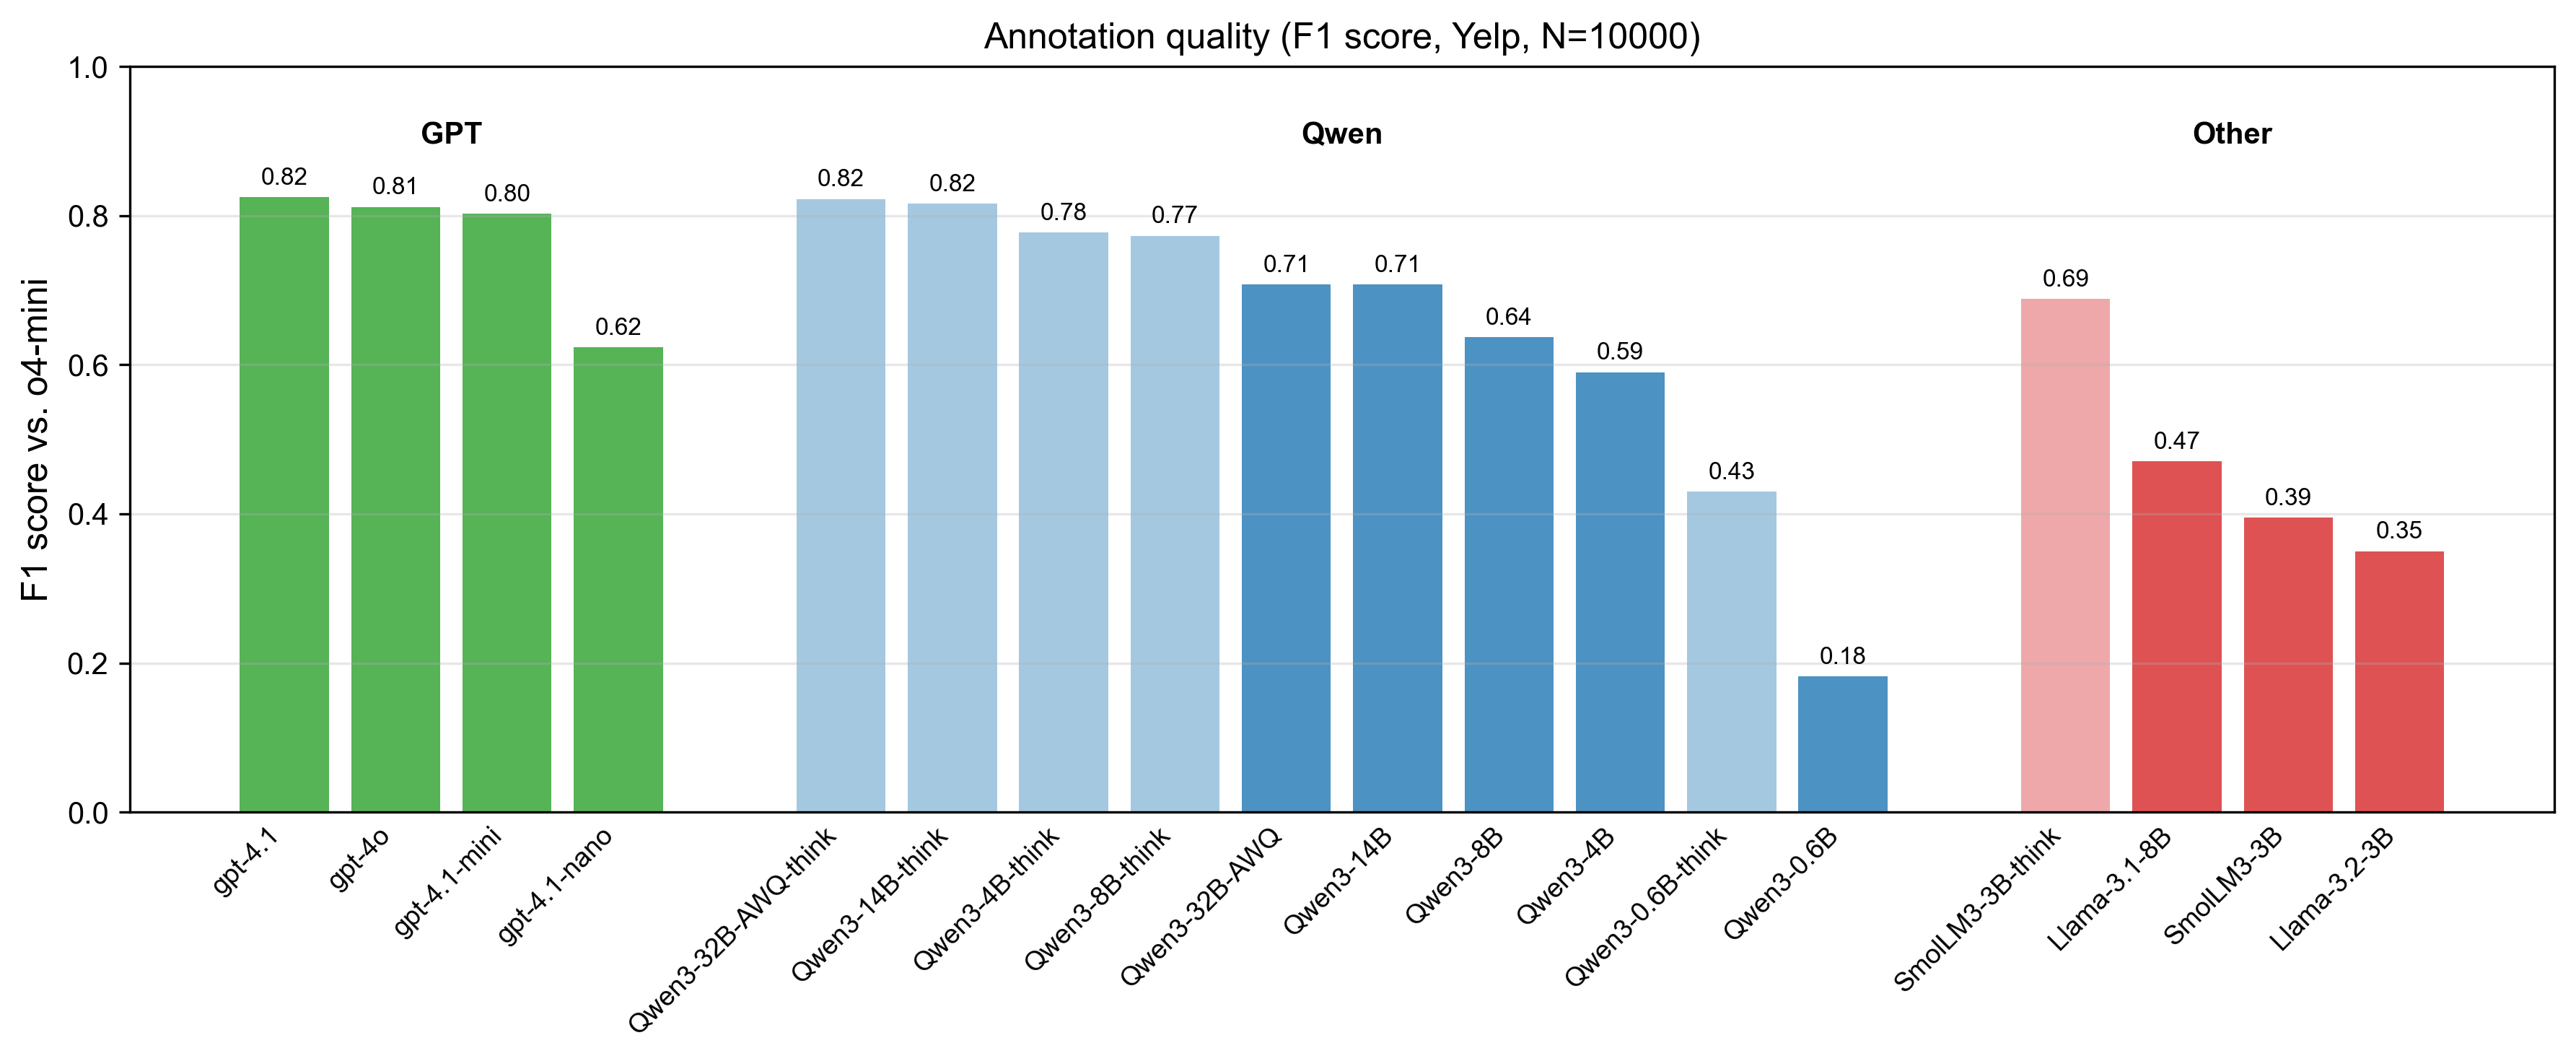

In [106]:
import matplotlib.pyplot as plt
import numpy as np

def get_group(m): return 'GPT' if 'gpt' in m else 'Qwen' if 'qwen' in m else 'Other'
def get_label(m, t): 
    n = m.split('/')[-1] if '/' in m else m
    return n + '-think' if t and not n.endswith('-think') else n

def plot_metric_bar(df, metric='r2', y_true_len=None):
    df = df.copy()
    df['group'] = df['model_name'].str.lower().map(get_group)
    df['label'] = [get_label(m, t) for m, t in zip(df['model_name'], df['thinking'])]

    # Sort by metric within each group
    grouped = [df[df['group']==g].sort_values(metric, ascending=False) for g in ['GPT','Qwen','Other']]
    plot_df = []
    for i, gdf in enumerate(grouped):
        if not gdf.empty:
            if plot_df: plot_df.append(None)
            plot_df.extend(gdf.to_dict('records'))

    fig, ax = plt.subplots(figsize=(2 + len(plot_df)*0.5, 5), dpi=300)
    colors = {'GPT':'C2','Qwen':'C0','Other':'C3'}
    alphas = {True:0.4, False:0.8}
    vals = [r[metric] if r else np.nan for r in plot_df]
    labels = [r['label'] if r else '' for r in plot_df]
    groups = [r['group'] if r else None for r in plot_df]

    for i, r in enumerate(plot_df):
        if not r: continue
        ax.bar(i, r[metric], 0.8, color=colors[r['group']], alpha=alphas[r['thinking']])
        ax.text(i, r[metric]+0.01, f"{r[metric]:.2f}", ha='center', va='bottom', fontsize=8)

    metric_label = {'f1':'F1 score','recall':'Recall','precision':'Precision','r2':'$R^2$'}.get(metric, metric)
    ax.set_ylabel(f'{metric_label} vs. {gt_model}', fontsize=12)
    ax.set_title(f'Annotation quality ({metric_label}, Yelp, N={y_true_len or "?"})', fontsize=12)
    ax.set_xticks(range(len(plot_df)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, 1)
    ax.grid(True, axis='y', alpha=0.3)
    ax.tick_params(axis='x', length=0)

    # Group labels
    for group in ['GPT','Qwen','Other']:
        idx = [i for i, g in enumerate(groups) if g==group]
        if idx:
            ax.text(np.mean(idx), np.nanmax(vals)*1.1, group, ha='center', va='center', fontsize=10, fontweight='bold', transform=ax.get_xaxis_transform())

    plt.tight_layout()
    plt.show()

plot_metric_bar(results_df, metric='f1', y_true_len=len(y_true))


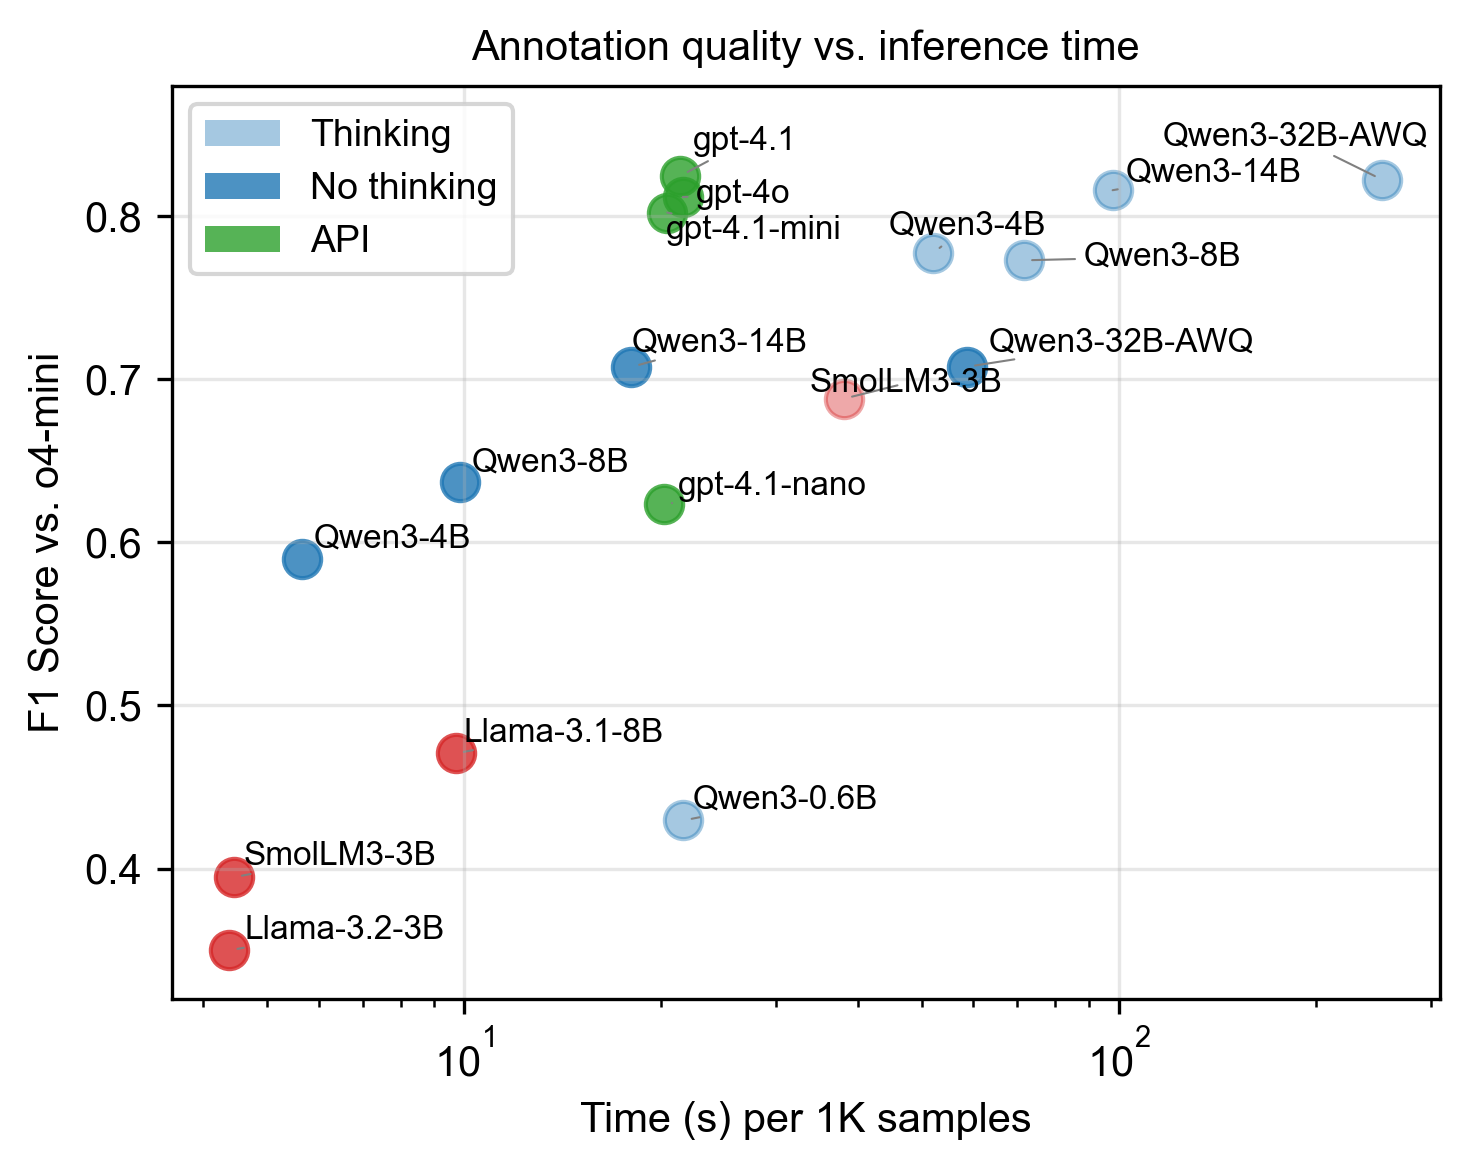

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text  # Added for better text placement

# Merge timing and results data on model_name
df_plot = pd.merge(df_timing, results_df, on=['model_name'])
df_plot['group'] = df_plot['model_name'].str.lower().map(get_group)
df_plot['time (s)'] = df_plot['time (s)'] / 10 # Compute time per 1K samples

# Color by group, but only legend by thinking
colors = {'GPT': 'C2', 'Qwen': 'C0', 'Other': 'C3'}
df_plot['color'] = df_plot['group'].map(colors)
alpha_map = {True: 0.4, False: 0.8}

fig, ax = plt.subplots(figsize=(5, 4), dpi=300)

texts = []
for idx, row in df_plot.iterrows():
    if row['f1'] < 0.3:
        continue
    ax.scatter(
        row['time (s)'], row['f1'],
        color=row['color'],
        alpha=alpha_map[row['thinking']],
        s=80, marker='o'
    )
    # Label each point with model name (abbreviated if needed)
    display_name = row['model_name'].replace('-think', '')
    text = ax.text(
        row['time (s)'], row['f1'],
        display_name,
        fontsize=8, ha='left', va='bottom'
    )
    texts.append(text)

ax.set_xscale('log')
ax.set_xlabel("Time (s) per 1K samples")
ax.set_ylabel("F1 Score vs. o4-mini")
ax.set_title("Annotation quality vs. inference time", fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.32, 0.88)

# Use adjust_text to avoid overlapping labels
adjust_text(texts, x=df_plot['time (s)'], y=df_plot['f1'], ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=.5))

# Custom legend: just thinking vs no thinking
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='C0', alpha=0.4, label='Thinking'),
    Patch(facecolor='C0', alpha=0.8, label='No thinking'),
    Patch(facecolor='C2', alpha=0.8, label='API'),
]
ax.legend(handles=legend_elements, fontsize=9)

plt.tight_layout()
plt.show()


## Get SAE activations for interpretation

In [42]:
base_dir = os.path.join('/nas/ucb/rmovva/data/hypothesaes', 'hypothesis-generation-data', 'yelp')
train_df = pd.read_json(os.path.join(base_dir, "train-200K.json"), lines=True)
val_df = pd.read_json(os.path.join(base_dir, "val-10K.json"), lines=True)

texts = train_df['text'].tolist()
labels = train_df['stars'].values
val_texts = val_df['text'].tolist() # These are only used for early stopping of SAE training, so we don't need labels.

In [43]:
from hypothesaes import get_local_embeddings

EMBEDDER = "nomic-ai/modernbert-embed-base" # Huggingface model, will run locally
CACHE_NAME = f"yelp_quickstart_{EMBEDDER}"

text2embedding = get_local_embeddings(texts + val_texts, model=EMBEDDER, batch_size=256, cache_name=CACHE_NAME)
embeddings = np.stack([text2embedding[text] for text in texts])

train_embeddings = np.stack([text2embedding[text] for text in texts])
val_embeddings = np.stack([text2embedding[text] for text in val_texts])

Loaded model nomic-ai/modernbert-embed-base to cuda


Processing chunks:   0%|          | 0/5 [00:00<?, ?it/s]

Chunk 0:   0%|          | 0/196 [00:00<?, ?it/s]

Saved 49997 embeddings to /home/rmovva/HypotheSAEs/emb_cache/yelp_quickstart_nomic-ai/modernbert-embed-base/chunk_000.npy


Chunk 1:   0%|          | 0/196 [00:00<?, ?it/s]

Saved 49998 embeddings to /home/rmovva/HypotheSAEs/emb_cache/yelp_quickstart_nomic-ai/modernbert-embed-base/chunk_001.npy


Chunk 2:   0%|          | 0/196 [00:00<?, ?it/s]

Saved 49999 embeddings to /home/rmovva/HypotheSAEs/emb_cache/yelp_quickstart_nomic-ai/modernbert-embed-base/chunk_002.npy


Chunk 3:   0%|          | 0/196 [00:00<?, ?it/s]

Saved 50000 embeddings to /home/rmovva/HypotheSAEs/emb_cache/yelp_quickstart_nomic-ai/modernbert-embed-base/chunk_003.npy


Chunk 4:   0%|          | 0/40 [00:00<?, ?it/s]

Saved 10000 embeddings to /home/rmovva/HypotheSAEs/emb_cache/yelp_quickstart_nomic-ai/modernbert-embed-base/chunk_004.npy


In [48]:
from hypothesaes.quickstart import train_sae

checkpoint_dir = '/nas/ucb/rmovva/data/hypothesaes/local_llm_experiments/checkpoints'
M, K, matryoshka = 1024, 32, [128, 1024]
sae = train_sae(embeddings=embeddings, M=M, K=K, matryoshka_prefix_lengths=matryoshka, checkpoint_dir=checkpoint_dir, val_embeddings=val_embeddings, n_epochs=50, patience=3, overwrite_checkpoint=True)
activations = sae.get_activations(embeddings)

np.save(os.path.join(checkpoint_dir, f'activations_{M}_{K}.npy'), activations)
print(activations.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

Saved model to /nas/ucb/rmovva/data/hypothesaes/local_llm_experiments/checkpoints/SAE_matryoshka_M=1024_K=32_prefixes=128-1024.pt


Computing activations (batchsize=16384):   0%|          | 0/13 [00:00<?, ?it/s]

(200000, 1024)
